# Modelo para Sweet Lift Taxi

## Índice <a id='back'></a>
* [Introducción](#intro)
* [Etapa 1. Descripción y preprocesamiento de los datos](#data_review)
    * [1. 1. Información general de los datos](#data_review_data)
    * [1. 2. Cambio de índice](#data_review_index)
    * [1. 3. Conclusiones](#data_review_conclusions)
* [Etapa 2. Análisis de datos](#data_analysis)
* [Etapa 3. Entrenamiento de modelos](#data_model)
    * [3. 1. Regresión lineal](#data_model_linear)
    * [3. 2. Árbol de decisión](#data_model_tree)
    * [3. 3. Bosque aleatorio](#data_model_forest)
    * [3. 4. CatBoost](#data_model_catboost)
    * [3. 5. LightGBM](#data_model_lightgbm)
    * [3. 6. Conclusiones](#data_model_conclusions)
* [Etapa 3. Análisis del modelo](#data_analysis)
* [Etapa 4. Conclusión general](#data_conclusion)

## Introducción <a id='intro'></a>

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropueretos con la finalidad de atraer a más conductores durante las horas pico. El objetivo de este proyecto es predecir la cantidad de pedidos de taxis para la próxima hora.

De esta manera, se entrenarán modelos para determinar dicha predicción, basados en diferentes algoritmos. Se utilizará la métrica RECM para evaluar la calidad de éstos. La meta es que este valor no debe ser superior a 48 en el conjunto de prueba.

Los datos se almacenan en el archivo `/datasets/taxi.csv`. Como se desconoce la calidad de los datos, el proyecto consistirá en cuatro etapas:

1. Descripción y preprocesamiento de los datos.
2. Análisis de datos.
3. Análisis del modelo.
4. Conclusión general.

[Volver a Contenidos](#back)

## Etapa 1. Descripción y preprocesamiento de los datos <a id='data_review'></a>

Se importan las librerías necesarias.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
import time

Se leerá el archivo y se guardará en la variable `data`. 

In [2]:
try:
    data = pd.read_csv('taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

### 1. 1. Información general de los datos <a id='data_review_data'></a>

Se imprimirá la información general de `data` y las primeras 10 filas de éste.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


El dataframe contiene 26,496 filas y 2 columnas, las cuales son:

1. `datetime` - fecha y hora registrada.
2. `num_orders` - cantidad de taxis pedidos.

Se observa que no existen valores ausentes. La columna `datetime` no está en el formato adecuado por lo que se cambiará el formato.

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Se investigará si existen filas duplicadas.

In [7]:
data.duplicated().sum()

0

No existen filas duplicadas.

[Volver a Contenidos](#back)

### 1. 2. Cambio de índice <a id='data_review_index'></a>

En esta sección se cambiará el índice del dataframe por la primera columna, esto es para analizar series de tiempo.

In [8]:
data = data.set_index(['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Se verificará si las fechas está en orden cronológico.

In [9]:
data.index.is_monotonic_increasing

True

El índice está en orden cronológico, así que se tienen datos registrados en el período del 1 de marzo al 31 de agosto del año 2018.

Como el objetivo es crear un modelo para predecir el número de pedidos en la próxima hora, entonces se remuestrearán los datos por períodos de una hora.

In [10]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


El dataframe está listo para el análisis que se realizará en la siguiente etapa.

[Volver a Contenidos](#back)

### 1. 3. Conclusiones <a id='data_review_conclusions'></a>

En esta etapa se abrió el archivo y se guardó en un dataset, el cual contiene información sobre la fecha de registro y la cantidad de pedidos realizados.

Se cambió el formato de la columna con fechas. No se encontraron valores ausentes ni filas duplicadas. Se convirtió la columna de la fecha de registro al índice del dataframe, se verificó que está en orden cronológico y se remuestreo para tener la información de los pedidos por hora.

En la siguiente etapa se analizarán los datos.

[Volver a Contenidos](#back)

## Etapa 2. Análisis de datos <a id='data_analysis'></a>

En esta etapa se analizará la tendencia y estacionalidad en diferentes períodos de tiempo. Primero se mostrará la gráfica del dataset donde las series de tiempo son de 1 hora.

<Axes: xlabel='datetime'>

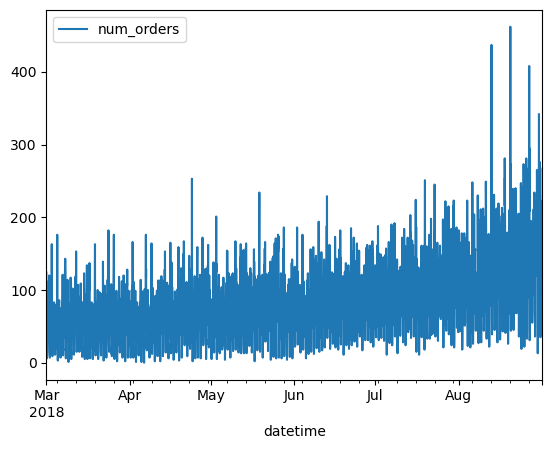

In [11]:
data.plot()

Es una gran cantidad de datos por lo que no se puede analizar de la mejor manera la gráfica. Por lo tanto, se dividirá la información en tendencia, estacionalidad y residuos. Además, se mostrarán sus gráficas correspondientes.

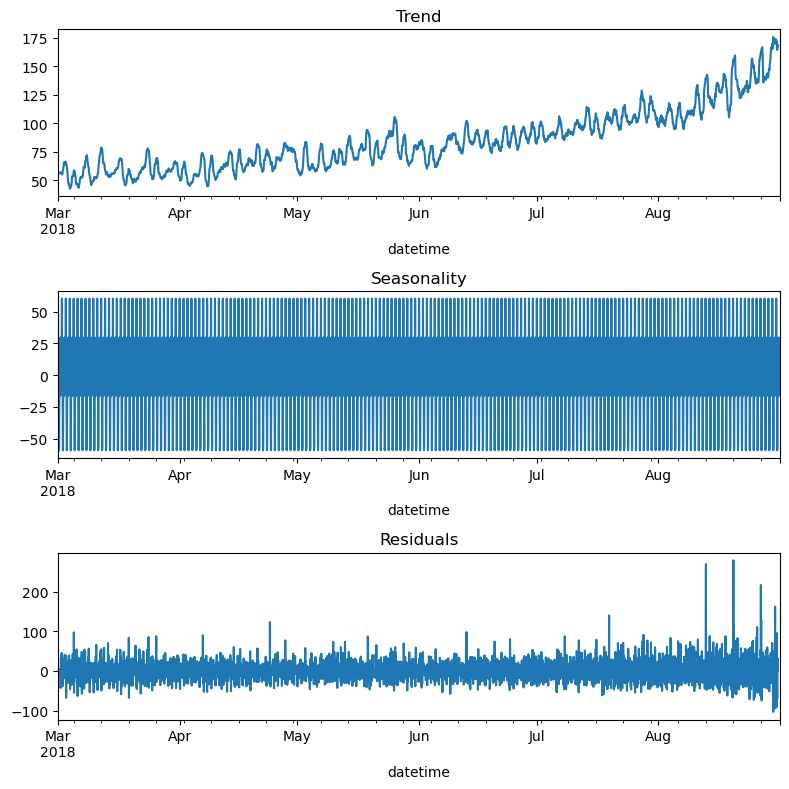

In [12]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Se observa una tendencia positiva a lo largo de los meses, la cual va aproximadamente de 40 a 175 pedidos. Sobre la estacionalidad no se puede concluir mucho, aún siguen siendo demasiados puntos.

Se remuestreará el dataset por día y se agregará tanto la media móvil como la desviación estándar móvil con una ventana de tamaño 7.

<Axes: xlabel='datetime'>

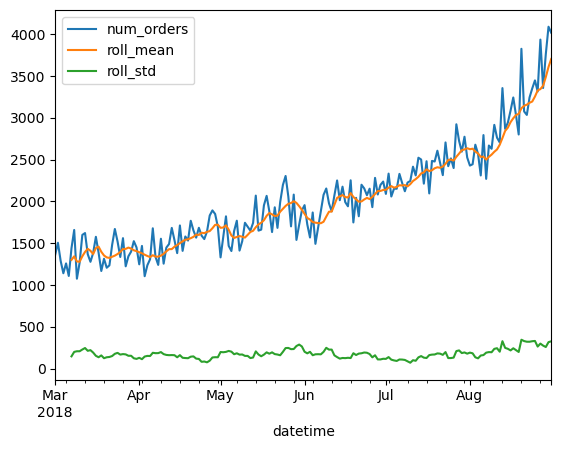

In [13]:
data_d = data.resample('1D').sum()
data_d['roll_mean']=data_d['num_orders'].rolling(7).mean()
data_d['roll_std']=data_d['num_orders'].rolling(7).std()

data_d.plot()

Se observa que la media aumenta al pasar el tiempo pero la desviación estándar no tiene fluctuaciones considerables. Esto quiere decir que no existe una diferencia considerable con respecto a la media a lo largo de los meses.

Para analizar de mejor manera la tendencia y estacionalidad, se considerará cualquier semana del período analizado. Se tomará la semana del 2018-05-14 a 2018-05-20 (de lunes a domingo).

Text(0.5, 1.0, 'Trend')

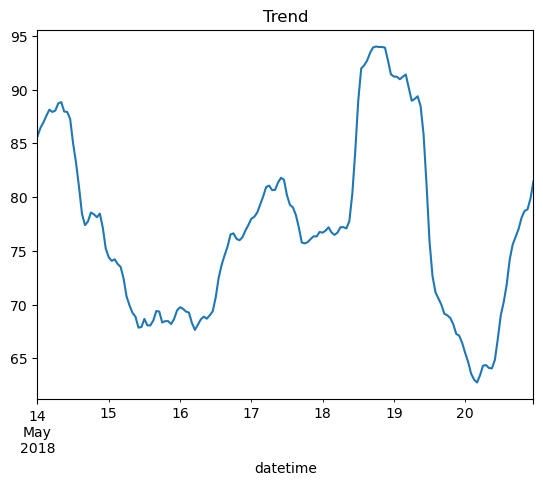

In [14]:
decomposed.trend['2018-05-14':'2018-05-20'].plot()
plt.title('Trend')

Text(0.5, 1.0, 'Seasonality')

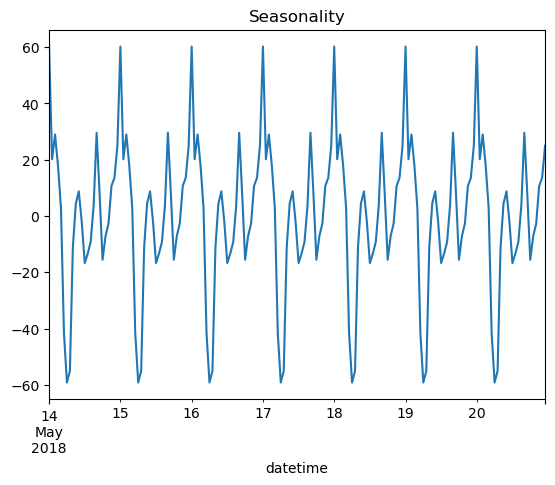

In [15]:
decomposed.seasonal['2018-05-14':'2018-05-20'].plot()
plt.title('Seasonality')

Se observa que entre el viernes por la noche y sábado por la mañana se registra la mayor cantidad de pedidos de la semana. Además se distingue un patrón por día: de las 00:00 hrs a aproximadamentes las 06:00 la cantidad de pedidos desciende, después de esa hora asciende, formando 3 picos, el más alto al terminar el día.

Se analizará la tendencia y estacionalidad de estos dos días.

Text(0.5, 1.0, 'Trend')

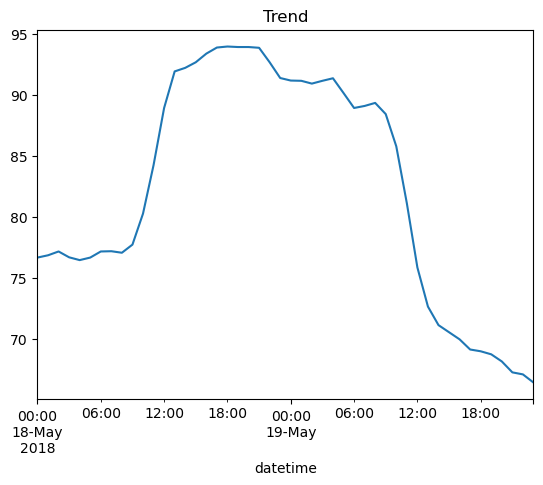

In [16]:
decomposed.trend['2018-05-18':'2018-05-19'].plot()
plt.title('Trend')

Text(0.5, 1.0, 'Seasonality')

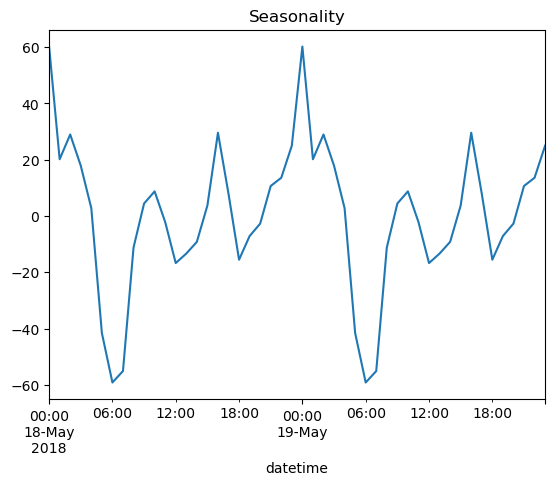

In [17]:
decomposed.seasonal['2018-05-18':'2018-05-19'].plot()
plt.title('Seasonality')

Con estas gráficas se observa que la hora pico está entre las 18:00 y 06:00 hrs.

**Conclusiones**

En esta etapa se analizaron las series temporales y se llegó a la conclusión de que el día con una mayor cantidad de pedidos es el sábado, mientras que la hora pico se registra entre las 18:00 y 06:00 hrs.

[Volver a Contenidos](#back)

## Etapa 3. Entrenamiento de modelos <a id='data_model'></a>

En esta etapa se entrenarán modelos para predecir el número de pedidos de taxi en la próxima hora (tarea de regresión).

Lo primero que se realizará es escribir una función para crear características. Los datos son únicamente del año 2018 y se observó que la media crece a lo largo de los meses, además, los sábados son los días con más pedidos y la hora pico es entre 18:00 y 06:00 hrs. Por estas razones, es necesario considerar mes, día, día de la semana y hora.

También son necesarias características de desfase, pues si el número de pedidos está definido por la función $X(t)$, entonces los valores anteriores en la serie pueden decir si $X(t)$ aumenta o disminuye. Se crearán características con un desfase de hasta 8 horas.

La media móvil establece la tendencia general de la serie temporal, se establecerá una ventana de 24 horas (día).

In [18]:
def make_features(df, max_lag, roll_size):
    #Características de calendario
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    #Características de desfase
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    #Media móvil
    df['rolling_mean'] = df['num_orders'].shift().rolling(roll_size).mean()
    
    #Eliminar filas con NaN
    df = df.dropna()
    return df

data2 = make_features(data, 8, 24)
data2.head()    

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,56.958333


Ahora se dividirá el dataset en conjunto de entrenamiento y prueba, donde este último debe ser el 10% del dataset inicial. Esta división no debe ser de forma aleatorio pues el orden cronológico es de suma importancia.

In [19]:
train, test = train_test_split(data2, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Se establecerán las características y el objetivo para los modelos.

In [20]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

for item in [features_train, target_train, features_test, target_test]:
    print(item.shape)

(3952, 13)
(3952,)
(440, 13)
(440,)


Para algunos algoritmos es necesario codificar las variables categóricas. Se creará un nuevo dataset con estas variables codificadas.

In [21]:
categorical = ['month', 'day', 'dayofweek', 'hour']

ohe = pd.get_dummies(data = data2, columns = categorical, drop_first=True)

train_ohe, test_ohe = train_test_split(ohe, shuffle=False, test_size=0.1)
print(train_ohe.index.min(), train_ohe.index.max())
print(test_ohe.index.min(), test_ohe.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [22]:
features_train_ohe = train_ohe.drop(['num_orders'], axis=1)
target_train_ohe = train_ohe['num_orders']
features_test_ohe = test_ohe.drop(['num_orders'], axis=1)
target_test_ohe = test_ohe['num_orders']

for item in [features_train_ohe, target_train_ohe, features_test_ohe, target_test_ohe]:
    print(item.shape)

(3952, 73)
(3952,)
(440, 73)
(440,)


Se utilizará la métrica RECM para evaluar la calidad de los modelos, por ello se creará la función, utilizando la función `mean_squared_error`.

In [23]:
def rmse(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    return mse ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

Finalmente, se creará una tabla para registrar la información resultante de entrenar los modelos y así poder compararlos.

In [24]:
model_info = pd.DataFrame(columns=('model','fit_time','predict_time','rmse'))
model_info.head()

,model,fit_time,predict_time,rmse


Ya se tiene lo necesario para comenzar el entrenamiento de los modelos.

[Volver a Contenidos](#back)

### 3. 1. Regresión lineal <a id='data_model_linear'></a>

El primer modelo a entrenar será basado en la regresión lineal. Este modelo se utilizará como prueba de cordura, esto es, será la métrica RECM a superar.

Se realizará validación cruzada.

In [25]:
lr_model = LinearRegression()
lr_score=cross_val_score(lr_model, features_train, target_train, scoring=rmse_scorer, cv=5)
print(lr_score.mean())

-30.508938680470607


Se entrenará al modelo y se tomará el tiempo, así como el tiempo de predicción y se calculará el RECM para adjuntar los datos en la tabla.

In [26]:
#fila con la información del modelo
lr_info = ['Linear Regression']

#Tomar tiempo de entrenamiento
start = time.time()
lr_model.fit(features_train, target_train)
end=time.time()

#agregar el tiempo de entrenamiento
lr_info.append(end - start)

#Tomar tiempo de predicción
start = time.time()
lr_predict = lr_model.predict(features_test)
end=time.time()

#agregar el tiempo de predicción
lr_info.append(end - start)

#RMSE
lr_rmse = rmse(target_test, lr_predict)

#add to row
lr_info.append(lr_rmse)

model_info.loc[len(model_info)] = lr_info
model_info.head()

,model,fit_time,predict_time,rmse
0,Linear Regression,0.004016,0.000884,51.308729


Se repetirá el mismo proceso pero con los datos codificados.

In [27]:
lr_model = LinearRegression()
lr_score=cross_val_score(lr_model, features_train_ohe, target_train_ohe, scoring=rmse_scorer, cv=5)
print(lr_score.mean())

-74792030089.53842


In [28]:
lr_ohe_info = ['Linear Regression OHE']

start = time.time()
lr_model.fit(features_train_ohe, target_train_ohe)
end=time.time()

lr_ohe_info.append(end - start)

start = time.time()
lr_ohe_predict = lr_model.predict(features_test_ohe)
end=time.time()

lr_ohe_info.append(end - start)

lr_ohe_rmse = rmse(target_test_ohe, lr_ohe_predict)

lr_ohe_info.append(lr_ohe_rmse)

model_info.loc[len(model_info)] = lr_ohe_info
model_info.head()

,model,fit_time,predict_time,rmse
0,Linear Regression,0.004016,0.000884,51.308729
1,Linear Regression OHE,0.018793,0.007305,45.294336


Se observa que con los datos codificados se tiene un valor RECM menor, incluso cumple la meta de ser menor a 48. Sin embargo, se investigará si con otros algoritmos se puede reducir este valor.

[Volver a Contenidos](#back)

### 3. 2. Árbol de decisión <a id='data_model_tree'></a>

A continuación se utilizará el algoritmo de árbol de decisión y se entrenarán modelos variando la profundidad y evaluando con validación cruzada.

In [29]:
best_score = 1000
best_depth = 0
for depth in range(1, 21):
    dt_model = DecisionTreeRegressor(max_depth=depth, random_state=54321)
    dt_score = cross_val_score(dt_model, features_train_ohe, target_train_ohe, scoring=rmse_scorer, cv=5)
    score = dt_score.mean()
    if abs(score) < best_score:
        best_score = abs(score)
        best_depth = depth
print('best_depth', best_depth, 'best_score:', best_score)

best_depth 7 best_score: 29.544470403715593


La profundidad con un valor RECM menor es 7. Se entrenará el modelo con esta profundidad.

In [30]:
dt_info = ['Decision Tree']

dt_model = DecisionTreeRegressor(max_depth=7, random_state=54321)

start = time.time()
dt_model.fit(features_train_ohe, target_train_ohe)
end=time.time()

dt_info.append(end - start)

start = time.time()
dt_predict = dt_model.predict(features_test_ohe)
end=time.time()

dt_info.append(end - start)

dt_rmse = rmse(target_test_ohe, dt_predict)

dt_info.append(dt_rmse)

model_info.loc[len(model_info)] = dt_info
model_info

,model,fit_time,predict_time,rmse
0,Linear Regression,0.004016,0.000884,51.308729
1,Linear Regression OHE,0.018793,0.007305,45.294336
2,Decision Tree,0.023754,0.000874,52.410695


El valor RECM es mayor que el obtenido de la regresión lineal por lo que queda descartado.

[Volver a Contenidos](#back)

### 3. 3. Bosque aleatorio <a id='data_model_forest'></a>

A continuación se utilizará el algoritmo de bosque aleatorio y se entrenarán modelos variando profundidad, cantidad de árboles y como se decorrelacionan los árboles entre sí. Se evaluará utilizando Grid Search basado en validación cruzada.

In [31]:
estimators = []
for i in range(1, 150, 10):
    estimators.append(i)

#diccionario de parámetros
parameters = {
    'n_estimators' : estimators,
    'max_features' : [9, 11, 13, 15],
    'max_depth' : [10, 20, 30, 40]
}

rf = RandomForestRegressor(random_state=54321)
grid = GridSearchCV(estimator=rf, param_grid=parameters, scoring=rmse_scorer, cv=3, n_jobs=-1, verbose=0)

grid.fit(features_train_ohe, target_train_ohe)

#Mejores parámetros
print('Resultados de GridSearch')
print("\n La mejor puntuación:", grid.best_score_)
print("\n Los mejores parámetros:\n", grid.best_params_)

best_param=grid.best_params_

Resultados de GridSearch

 La mejor puntuación: -27.308099981312537

 Los mejores parámetros:
 {'max_depth': 30, 'max_features': 15, 'n_estimators': 111}


Se utilizarán los mejores parámetros para reentrenar el modelo y analizar la información.

In [32]:
rf_info = ['Random Forest']

rf_model = RandomForestRegressor(
    n_estimators=best_param['n_estimators'],
    max_depth=best_param['max_depth'],
    max_features=best_param['max_features'],
    random_state=54321
)

start = time.time()
rf_model.fit(features_train_ohe, target_train_ohe)
end=time.time()

rf_info.append(end - start)

start = time.time()
rf_predict = rf_model.predict(features_test_ohe)
end=time.time()

rf_info.append(end - start)

rf_rmse = rmse(target_test_ohe, rf_predict)

rf_info.append(rf_rmse)

model_info.loc[len(model_info)] = rf_info
model_info

,model,fit_time,predict_time,rmse
0,Linear Regression,0.004016,0.000884,51.308729
1,Linear Regression OHE,0.018793,0.007305,45.294336
2,Decision Tree,0.023754,0.000874,52.410695
3,Random Forest,0.677831,0.007099,46.366534


El valor RECM de este modelo es menor que el entrenado con árbol de decisión, sin embargo, es mayor que el de la regresión lineal.

[Volver a Contenidos](#back)

### 3. 4. CatBoost <a id='data_model_catboost'></a>

Se utilizará CatBoostRegressor para entrenar al modelo. Este algoritmo no necesita la codificación de las variables categóricas. Se utilizarán diferentes hiperparámetros y se encontrarán los mejores utilizando Grid Search basado en validación cruzada.

In [33]:
cbr_model = CatBoostRegressor()

#diccionario de parámetros
parameters = {
    'depth' : [4, 6, 8],
    'learning_rate' : [0.05, 0.1],
    'iterations' : [20, 50, 100]
}

grid = GridSearchCV(estimator=cbr_model, param_grid=parameters, scoring=rmse_scorer, cv=3, n_jobs=-1, verbose=0)

grid.fit(features_train, target_train, cat_features=categorical)

print('Resultados de GridSearch')
print("\n La mejor puntuación:", grid.best_score_)
print("\n Los mejores parámetros:\n", grid.best_params_)

best_param=grid.best_params_

0:	learn: 32.6099977	total: 61.7ms	remaining: 1.17s
0:	learn: 32.9874113	total: 62ms	remaining: 1.18s
0:	learn: 38.4273062	total: 61.7ms	remaining: 1.17s
0:	learn: 40.0036243	total: 61.6ms	remaining: 3.02s
0:	learn: 40.0036243	total: 62ms	remaining: 1.18s
0:	learn: 38.4273062	total: 62.1ms	remaining: 3.04s
0:	learn: 37.9762355	total: 62.3ms	remaining: 1.18s
0:	learn: 39.2888230	total: 62.2ms	remaining: 1.18s
1:	learn: 39.3506745	total: 63.3ms	remaining: 1.52s
1:	learn: 32.5563433	total: 64.2ms	remaining: 578ms
1:	learn: 37.9754877	total: 64.3ms	remaining: 1.54s
1:	learn: 31.8072404	total: 64ms	remaining: 576ms
1:	learn: 39.3506745	total: 64.4ms	remaining: 580ms
1:	learn: 37.1584458	total: 65.3ms	remaining: 587ms
1:	learn: 38.0412186	total: 65.3ms	remaining: 588ms
2:	learn: 38.7556559	total: 65.3ms	remaining: 1.02s
1:	learn: 37.9754877	total: 65.5ms	remaining: 590ms
2:	learn: 32.1484848	total: 66.5ms	remaining: 377ms
2:	learn: 30.6322977	total: 66.1ms	remaining: 375ms
2:	learn: 37.15840

Con estos parámetros se reentrenará el modelo y se tomará el tiempo.

In [34]:
cbr_info = ['CatBoostRegressor']

cbr_model = CatBoostRegressor(
    depth=best_param['depth'],
    iterations=best_param['iterations'],
    learning_rate=best_param['learning_rate']
)

start = time.time()
cbr_model.fit(features_train, target_train, cat_features=categorical, verbose=False, plot=False)
end=time.time()

cbr_info.append(end - start)

start = time.time()
cbr_predict = cbr_model.predict(features_test)
end=time.time()

cbr_info.append(end - start)

cbr_rmse = rmse(target_test, cbr_predict)

cbr_info.append(cbr_rmse)

model_info.loc[len(model_info)] = cbr_info
model_info

,model,fit_time,predict_time,rmse
0,Linear Regression,0.004016,0.000884,51.308729
1,Linear Regression OHE,0.018793,0.007305,45.294336
2,Decision Tree,0.023754,0.000874,52.410695
3,Random Forest,0.677831,0.007099,46.366534
4,CatBoostRegressor,0.068744,0.000818,45.667878


El valor RECM de este modelo es menor que el del bosque aleatorio pero no al de regresión lineal.

[Volver a Contenidos](#back)

### 3. 5. LightGBM <a id='data_model_lightgbm'></a>

En esta sección se utilizará LightGBM para entrenar el modelo. Lo primero que se debe hacer es convertir las variables categóricas al tipo correcto.

In [35]:
for item in categorical:
    features_train[item] = features_train[item].astype('category')
    features_test[item] = features_test[item].astype('category')

Así como con el anterior, se utilizarán diferentes parámetros y con GridSearchCV se encontrarán los mejores.

In [36]:
model=LGBMRegressor()

parameters = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.5, 0.1, 0.01],
    'n_estimators': [30, 40, 50]
}

grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=rmse_scorer, cv=3, n_jobs=-1)
grid.fit(features_train, target_train)
best_param=grid.best_params_

print('Resultados de GridSearch')
print("\n La mejor puntuación:", grid.best_score_)
print("\n Los mejores parámetros:\n", grid.best_params_)

Resultados de GridSearch

 La mejor puntuación: -27.30318740696283

 Los mejores parámetros:
 {'learning_rate': 0.1, 'n_estimators': 40, 'num_leaves': 30}


Con estos parámetros se entrenará el modelo y se tomará el tiempo.

In [37]:
lgbm_info = ['LightGBMRegressor']

lgbm_model = LGBMRegressor(
    learning_rate=best_param['learning_rate'],
    n_estimators=best_param['n_estimators'],
    num_leaves=best_param['num_leaves']
)

start = time.time()
lgbm_model.fit(features_train, target_train)
end=time.time()

lgbm_info.append(end - start)

start = time.time()
lgbm_predict = lgbm_model.predict(features_test)
end=time.time()

lgbm_info.append(end - start)

lgbm_rmse = rmse(target_test, lgbm_predict)

lgbm_info.append(lgbm_rmse)

model_info.loc[len(model_info)] = lgbm_info
model_info

,model,fit_time,predict_time,rmse
0,Linear Regression,0.004016,0.000884,51.308729
1,Linear Regression OHE,0.018793,0.007305,45.294336
2,Decision Tree,0.023754,0.000874,52.410695
3,Random Forest,0.677831,0.007099,46.366534
4,CatBoostRegressor,0.068744,0.000818,45.667878
5,LightGBMRegressor,0.064313,0.001963,43.070724


Este modelo es el que registra el menor valor RECM y sus tiempos de entrenamiento y predicción no tienen una gran diferencia con el de regresión lineal (mejores tiempos). Se concluye que este modelo es el de mayor calidad.

[Volver a Contenidos](#back)

### 3. 6. Conclusiones <a id='data_model_conclusions'></a>

En esta etapa se entrenaron modelos usando los algoritmos: regresión lineal, árbol de decisión, bosque aleatorio, CatBoost y LightGBM.

Se utilizaron diferentes hiperparámetros para cada uno de ellos y utilizando validación cruzada, o bien, GridSearchCV, se decidió cuales eran los mejores.

Con esto parámetros se entrenaron los diferentes modelos y se tomaron los tiempos tanto de entrenamiento como de predicción. La métrica de evaluación fue el RECM.

El modelo con mayor calidad fue el entrenado con LightGBM.

[Volver a Contenidos](#back)

## Etapa 4. Conclusión general <a id='data_conclusion'></a>

En la primera etapa se preprocesaron los datos, en primer lugar se cambiaron los datos correspondientes a formato fecha. No se encontraron valores ausentes ni filas duplicadas. Se cambió el índice del dataset por la columna de las fechas de registro.

En la segunda etapa se analizaron lo datos, llegando a la conclusión que los días de la semana con mayor cantidad de pedidos son los viernes y sábados. Además, la hora del día con mayor cantidad de pedidos es entre las 18:00 y 06:00 hrs.

En la tercera etapa se entrenaron modelos utilizando cinco algoritmos diferentes. Se variaron los hiperpárametros y con validación cruzada o con Grid Search se encontró el que tiene menor RECM y buenos tiempos de entrenamiento y predicción. El modelo con las mejores puntuaciones fue el realizado con LightGBMRegressor. Por esta razón se concluyó que es el modelo más apropiado tomando en cuenta los requerimientos del cliente (RECM menor a 48).

[Volver a Contenidos](#back)